### Métodos Clássicos

In [2]:
# importando bibliotecas utilizadas
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.model_selection import TimeSeriesSplit

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# carrega dados da série histórica do csv
stocks_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/investHub/data/clean/clean_dataset.csv", delimiter=';')

# transforma coluna 'Ano' para datetime, de modo que o Pandas possa reconhecê-la
stocks_df.Ano = pd.to_datetime(stocks_df.Ano,format='%Y')
stocks_df.Ano = stocks_df.Ano.apply(lambda df: df.replace(month=12,day=31))

# define coluna Ano como indice
stocks_df.set_index('Ano', inplace=True)
stocks_df.info()
stocks_df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3187 entries, 2020-12-31 to 2021-12-31
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   LPA            3187 non-null   float64
 1   P_L            3187 non-null   float64
 2   VPA            3187 non-null   float64
 3   P_VP           3187 non-null   float64
 4   P_EBIT         3187 non-null   float64
 5   P_EBITDA       3187 non-null   float64
 6   P_Ativos       3187 non-null   float64
 7   Ebitda         3187 non-null   float64
 8   Marg_Ebitda    3187 non-null   float64
 9   PSR            3187 non-null   float64
 10  ROE            3187 non-null   float64
 11  ROA            3187 non-null   float64
 12  ROIC           3187 non-null   float64
 13  EV_EBIT        3187 non-null   float64
 14  EV_EBITDA      3187 non-null   float64
 15  Div_Yield      3187 non-null   float64
 16  Div_Payout     3187 non-null   float64
 17  Beta           3187 non-null   flo

,LPA,P_L,VPA,P_VP,P_EBIT,P_EBITDA,P_Ativos,Ebitda,Marg_Ebitda,PSR,...,ROIC,EV_EBIT,EV_EBITDA,Div_Yield,Div_Payout,Beta,Valorizacao,Negocios_dia,Volume_diario,Ticker
Ano,,,,,,,,,,,,,,,,,,,,,
2020-12-31,0.09,134.45,3.45,3.67,86.69,0.0,2.71,0.0,0.0,10.46,...,0.07,65.78,0.0,0.0040,0.0,0.28,0.04,2242,30,BOAS3
2021-12-31,0.09,130.65,3.49,3.31,91.06,0.0,2.48,0.0,0.0,9.52,...,0.06,73.32,0.0,0.0061,0.0,0.54,-0.09,2499,12,BOAS3
1998-12-31,19.53,4.69,302.40,0.30,2.05,0.0,0.17,0.0,0.0,0.82,...,0.09,24.77,0.0,0.0000,0.0,0.00,-0.68,63,2,SBSP3
1999-12-31,-8.23,-25.78,290.85,0.73,4.59,0.0,0.40,0.0,0.0,1.86,...,0.09,24.15,0.0,0.0000,0.0,0.00,1.23,72,2,SBSP3
2000-12-31,18.33,9.49,290.32,0.60,3.73,0.0,0.33,0.0,0.0,1.48,...,0.09,24.00,0.0,0.0000,0.0,0.76,-0.17,109,3,SBSP3


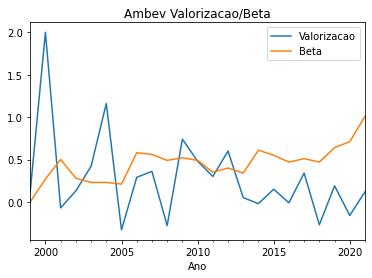

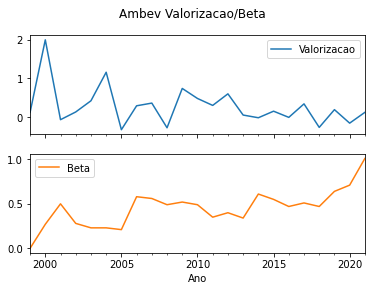

In [4]:
# plota duas séries temporias em mesmo plot
ABEV3_df = stocks_df.loc[stocks_df['Ticker'] == 'ABEV3']
ABEV3_df[['Valorizacao', 'Beta']].plot(title='Ambev Valorizacao/Beta')

# plota duas séries temporais em plots distintos
ABEV3_df[['Valorizacao', 'Beta']].plot(title='Ambev Valorizacao/Beta', subplots=True)

# imprime plots
plt.show()

In [5]:
# define frequência diaria
ABEV3_df_daily = ABEV3_df[['Valorizacao']].asfreq('D')
ABEV3_df_daily.info()
ABEV3_df_daily.head(100)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8037 entries, 1999-12-31 to 2021-12-31
Freq: D
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Valorizacao  23 non-null     float64
dtypes: float64(1)
memory usage: 125.6 KB


,Valorizacao
Ano,
1999-12-31,0.12
2000-01-01,NaN
2000-01-02,NaN
2000-01-03,NaN
2000-01-04,NaN
...,...
2000-04-04,NaN
2000-04-05,NaN
2000-04-06,NaN


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff0a1852150>,
      dtype=object)

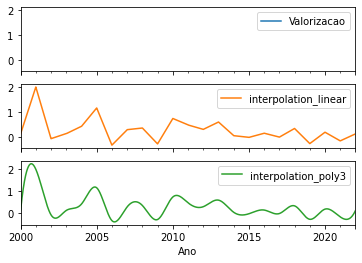

In [6]:
# interpolação com método linear
ABEV3_df_daily['interpolation_linear'] = ABEV3_df_daily.Valorizacao.interpolate(method='linear')

# interpolação com método polinomial
ABEV3_df_daily['interpolation_poly3'] = ABEV3_df_daily.Valorizacao.interpolate(method='polynomial', order=3)

# imprime resultados
ABEV3_df_daily[['Valorizacao','interpolation_linear','interpolation_poly3']].plot(subplots=True)


Tamanho do conjunto de treino:  (6211,)
Tamanho do conjunto de teste:   (1826,)


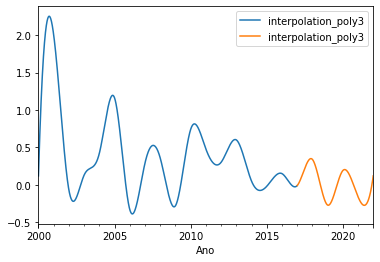

In [7]:
# split entre série de treino e teste
train_ts = ABEV3_df_daily[:'2016-12'].interpolation_poly3
test_ts = ABEV3_df_daily['2017-01':].interpolation_poly3

pd.concat([train_ts, test_ts], axis=1, sort=False).plot()

# tamanho da divisão:
print("Tamanho do conjunto de treino: ", train_ts.shape)
print("Tamanho do conjunto de teste:  ", test_ts.shape)

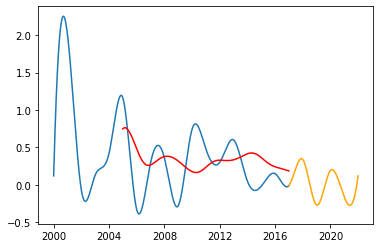

In [8]:
# média móvel dos últimos 5 anos
moving_avg = train_ts.rolling(window=1825).mean()
plt.plot(train_ts)
plt.plot(moving_avg, color='red')
plt.plot(test_ts, color='orange')

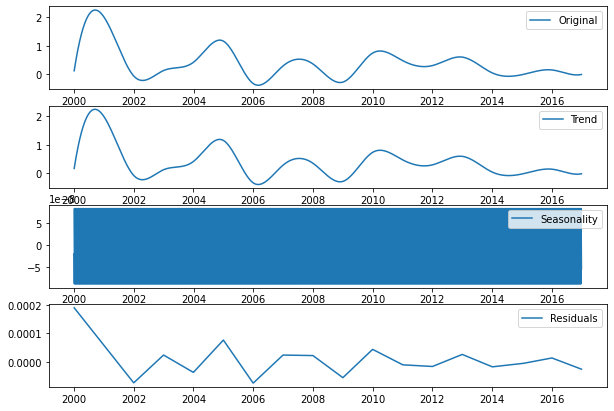

In [9]:

# cria modelo
decomposition = seasonal_decompose(train_ts, model='additive')

# define os componentes
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# plots
plt.subplots(figsize=(10, 7))
plt.subplot(411)
plt.plot(train_ts, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

In [10]:
# cria classe
expsmoothing = ExponentialSmoothing(train_ts)

# fit do modelo
expsmoothing_fit = expsmoothing.fit()

# previsao
expsmoothing_yhat = expsmoothing_fit.predict(start=test_ts.index[0], end=test_ts.index[-1])

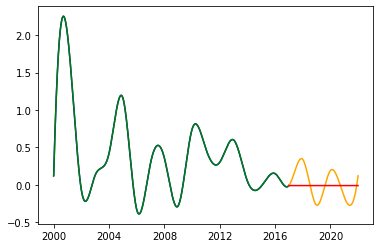

In [11]:
# plot dos resultados nos dados de treino:
plt.plot(train_ts, color='blue')
plt.plot(expsmoothing_fit.predict(start=train_ts.index[0], end=train_ts.index[-1]), color='green')

# Plot da previsão nos dados de teste
plt.plot(test_ts, color='orange')
plt.plot(expsmoothing_yhat, color='red')

In [12]:
# dataset para medir erro
exp_forecast = pd.concat([train_ts.append(test_ts),
                          expsmoothing_yhat.rename('yhat')], axis=1, sort=False)

exp_forecast.tail()

,interpolation_poly3,yhat
2021-12-27,0.103882,-0.01
2021-12-28,0.107874,-0.01
2021-12-29,0.111891,-0.01
2021-12-30,0.115933,-0.01
2021-12-31,0.120000,-0.01


In [23]:
# função para cálculo de erros
def calculate_forecast_errors(df, prediction_size):
    
    df = df.copy()
    
    df['e'] = df['interpolation_poly3'] - df['yhat']
    df['p'] = 100 * df['e'] / df['interpolation_poly3']
    
    predicted_part = df[-prediction_size:]
    
    error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))
    
    return {'MAPE': error_mean('p'), 'MAE': error_mean('e')}

In [24]:
# métricas de erro
for err_name, err_value in calculate_forecast_errors(exp_forecast, len(test_ts)).items():
    print(err_name, err_value)

MAPE 139.5777020771158
MAE 0.17116908372643724


In [17]:
# ARIMA
# importando a biblioteca
from statsmodels.tsa.arima_model import ARIMA

# fit do modelo
ar_model = ARIMA(train_ts, order=(0, 1, 1))  # especificando a ordem do ARIMA: order=(p, d, q)
ar_fit = ar_model.fit(disp=False)

# previsão
ar_yhat = ar_fit.predict(test_ts.index[0], test_ts.index[-1], typ='levels')

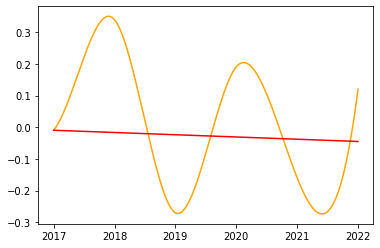

In [18]:
# plot results
plt.plot(test_ts, color='orange')
plt.plot(ar_yhat, color='red')

In [25]:
# dataset para medir erro
arima_forecast = pd.concat([train_ts.append(test_ts),
                            ar_yhat.rename('yhat')], axis=1, sort=False)

arima_forecast.tail()

,interpolation_poly3,yhat
2021-12-27,0.103882,-0.045008
2021-12-28,0.107874,-0.045028
2021-12-29,0.111891,-0.045047
2021-12-30,0.115933,-0.045066
2021-12-31,0.120000,-0.045086


In [26]:
# métricas de erro
for err_name, err_value in calculate_forecast_errors(arima_forecast, len(test_ts)).items():
    print(err_name, err_value)

MAPE 194.9277253481404
MAE 0.16870495847218284


In [27]:
# Prophet
# ajuste do dataset de treino
train_prophet = train_ts.reset_index()
train_prophet.columns = ['ds', 'y']
train_prophet.head()

,ds,y
0,1999-12-31,0.120000
1,2000-01-01,0.138510
2,2000-01-02,0.156924
3,2000-01-03,0.175244
4,2000-01-04,0.193468


In [28]:
# adjust do dataset de teste
test_prophet = test_ts.reset_index()
test_prophet.columns = ['ds', 'y']
test_prophet.head()

,ds,y
0,2017-01-01,-0.009378
1,2017-01-02,-0.008743
2,2017-01-03,-0.008096
3,2017-01-04,-0.007437
4,2017-01-05,-0.006766


In [29]:
# imports
from fbprophet import Prophet
# instancia prophet e treina
m = Prophet()
m.fit(train_prophet)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [30]:
# construção do dataset de teste para alimentar o modelo
future = m.make_future_dataframe(periods=len(test_prophet))

# realiza previsão
forecast = m.predict(future)

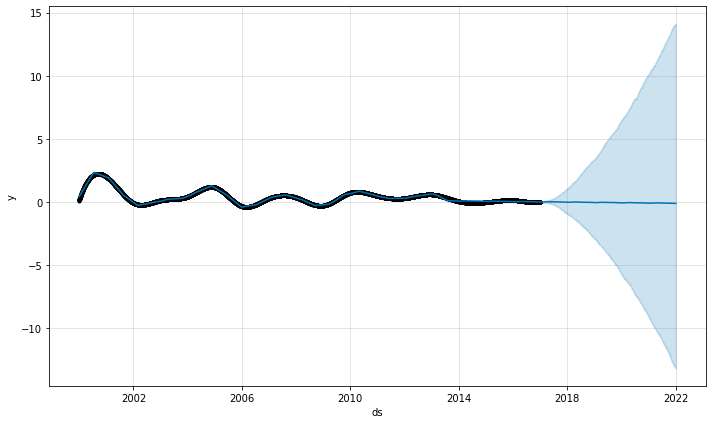

In [31]:
# plot dos resultados
m.plot(forecast);

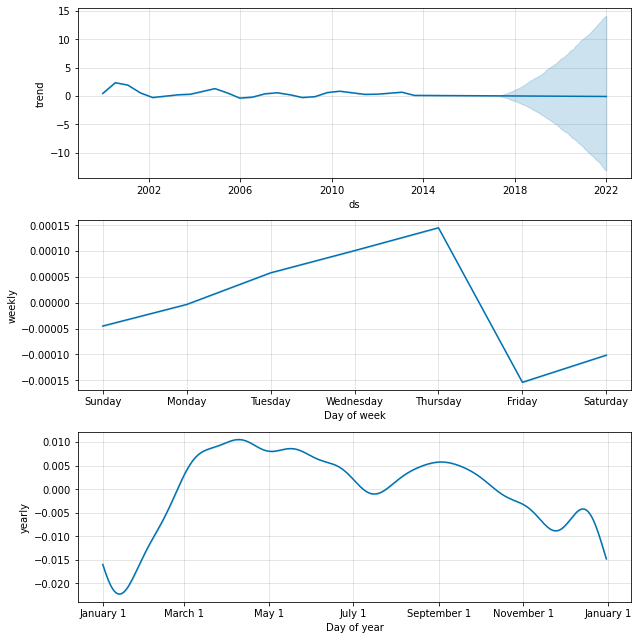

In [32]:
# plot das componentes da série
m.plot_components(forecast);

In [33]:
# função para construir dataset com valores históricos e previsão realizada
def make_comparison_dataframe(historical, forecast):
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical.set_index('ds'))

In [34]:
# usa função para construir dataset
prophet_forecast = make_comparison_dataframe(train_prophet.append(test_prophet), forecast)

prophet_forecast.tail()

,yhat,yhat_lower,yhat_upper,y
ds,,,,
2021-12-27,-0.106105,-13.107899,14.052268,0.103882
2021-12-28,-0.107057,-13.078702,14.072542,0.107874
2021-12-29,-0.108044,-13.128397,13.968964,0.111891
2021-12-30,-0.109036,-13.187648,14.126908,0.115933
2021-12-31,-0.110365,-13.152238,14.076346,0.120000


In [38]:
# função para cálculo de erros
def calculate_forecast_errors_prophet(df, prediction_size):
    
    df = df.copy()
    
    df['e'] = df['y'] - df['yhat']
    df['p'] = 100 * df['e'] / df['y']
    
    predicted_part = df[-prediction_size:]
    
    error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))
    
    return {'MAPE': error_mean('p'), 'MAE': error_mean('e')}

In [39]:
# cálculo de erros
for err_name, err_value in calculate_forecast_errors_prophet(prophet_forecast, len(test_ts)).items():
    print(err_name, err_value)

MAPE 208.35070488400146
MAE 0.16127922188961902


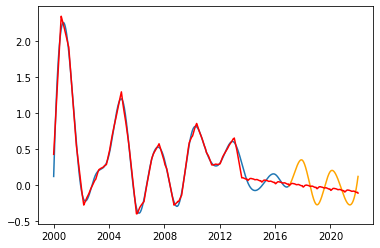

In [40]:
# plot dos resultados
plt.plot(train_ts)
plt.plot(test_ts, color='orange')
plt.plot(prophet_forecast['yhat'], color='red')

### Métodos de Machine Learning

In [59]:
ABEV3_df = ABEV3_df.drop("Ticker", axis=1)
# separando variável objetivo
X, y = ABEV3_df.loc[:, ABEV3_df.columns != "Valorizacao"], ABEV3_df.loc[:, ABEV3_df.columns == "Valorizacao"]

print("X", X.shape)
print(X.head())
print("y", y.shape)
print(y.head)

X (23, 20)
              LPA    P_L     VPA  P_VP  P_EBIT  P_EBITDA  P_Ativos  Ebitda  \
Ano                                                                          
1999-12-31 -27.21 -29.33  456.65  1.75   39.66       0.0      0.60     0.0   
2000-12-31  20.47  22.96   92.87  5.06   25.62       0.0      2.10     0.0   
2001-12-31  24.42  17.53   89.38  4.79   11.04       0.0      1.50     0.0   
2002-12-31  41.51  11.52  109.99  4.35    8.90       0.0      1.48     0.0   
2003-12-31  37.93  16.74  118.80  5.35   13.59       0.0      1.62     0.0   

            Marg_Ebitda   PSR   ROE   ROA  ROIC  EV_EBIT  EV_EBITDA  \
Ano                                                                   
1999-12-31          0.0  2.22 -0.06 -0.02  0.02  2058.34        0.0   
2000-12-31          0.0  3.46  0.22  0.09  0.09   401.57        0.0   
2001-12-31          0.0  2.53  0.27  0.09  0.14   191.78        0.0   
2002-12-31          0.0  2.50  0.38  0.13  0.18   139.66        0.0   
2003-12-31      

In [60]:
# import função train_test_split
from sklearn.model_selection import train_test_split

# usamos a função train_test_split para criar os sets de treino e teste
# define o tamanho do set de teste. Pode ser um inteiro (número de observações) ou então uma fração, correspondendo à proporção treino/teste
# suffle = False significa que a separação obedecerá a sequencia da data
X_training, X_test, y_training, y_test = train_test_split(X, y, 
                                                          test_size = 0.25, 
                                                          shuffle = False)

print("Train set X", X_training.shape)
print("Train set y", y_training.shape)
print("Test set X", X_test.shape)
print("Test set y", y_test.shape)
X_test.head()
X_test_backup = X_test

Train set X (17, 20)
Train set y (17, 1)
Test set X (6, 20)
Test set y (6, 1)


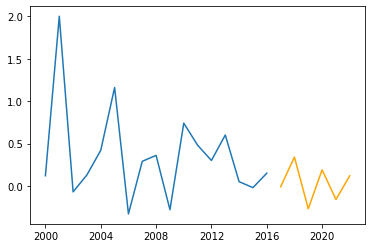

In [61]:
# plot dos dados
plt.plot(y_training)
plt.plot(y_test, color='orange')

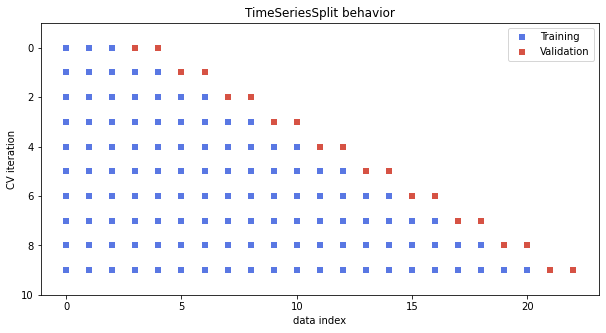

In [62]:
# usando uma janela expansiva para a validação cruzada
from sklearn.model_selection import TimeSeriesSplit
cv = TimeSeriesSplit(n_splits=10)

# agrora plotando os conjuntos de dados da validação cruzada
fig, ax = plt.subplots(figsize=(10, 5))
for index, (X_train, X_test) in enumerate(cv.split(X)):
    # Plot training and test indices
    l1 = ax.scatter(X_train, [index] * len(X_train), c=[plt.cm.coolwarm(.1)], marker='_', lw=6)
    l2 = ax.scatter(X_test, [index] * len(X_test), c=[plt.cm.coolwarm(.9)], marker='_', lw=6)
    ax.set(ylim=[10, -1], title='TimeSeriesSplit behavior', xlabel='data index', ylabel='CV iteration')
    ax.legend([l1, l2], ['Training', 'Validation'])

In [63]:
# Importando as bibliotecas que vamos utilizar no modelo
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import (explained_variance_score, 
                             mean_absolute_error, 
                             mean_squared_error, 
                             mean_squared_log_error,
                             r2_score)
from sklearn.model_selection import GridSearchCV

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.7


 Best hyperparameters:
{'max_depth': 5, 'max_features': 3, 'n_estimators': 100}
Pontuação média nos dados de treino: 0.851 +/- 0.018
Pontuação média nos dados de validação: nan +/- nan


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestRegressor(max_depth=5, max_features=3)

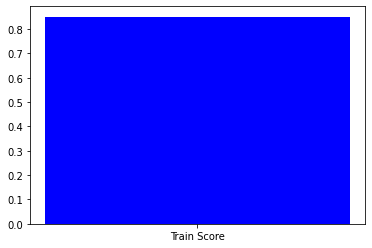

In [64]:
# Random Forest com Validação cruzada e Grid Search para Séries temporais

# define os valores possíveis para os parâmetros a serem testados
params = {'n_estimators': [100, 500],
          'max_features': [3, 5],
          'max_depth': [5, 10]}

# cria modelo
rf_model_cv_gs = RandomForestRegressor()

# objeto para grid search com GridSearchCV
grid_search = GridSearchCV(rf_model_cv_gs, 
                           param_grid = params, 
                           return_train_score = True, 
                           cv = cv)

# treina modelo com Grid Search
grid_search.fit(X_training, y_training)

# imprime melhor combinação de hiperparâmetros
print('\n Best hyperparameters:')
print(grid_search.best_params_)

# resultados do cv
cv_results = pd.DataFrame(grid_search.cv_results_)

# print score médio nos sets de treino
print("Pontuação média nos dados de treino: {:.3f} +/- {:.3f}".format(cv_results[cv_results.rank_test_score == 1].mean_train_score.values[0],
                                                                     cv_results[cv_results.rank_test_score == 1].std_train_score.values[0]))
# print score médio nos sets de validação
print("Pontuação média nos dados de validação: {:.3f} +/- {:.3f}".format(cv_results[cv_results.rank_test_score == 1].mean_test_score.values[0],
                                                                     cv_results[cv_results.rank_test_score == 1].std_test_score.values[0])) 

y = [cv_results[cv_results.rank_test_score == 1].mean_train_score.values[0], 
     cv_results[cv_results.rank_test_score == 1].mean_test_score.values[0]]
x = ["Train Score", "Test Score"]
width = 1/2
plt.bar(x, y, width, color="blue")  

# seta melhor opção baseada nos hiperparâmetros
# utiliza as melhores opções de hiperparâmetros encontrados
rf_model_cv_gs.set_params(n_estimators = grid_search.best_params_['n_estimators'],
                           max_features = grid_search.best_params_['max_features'],
                           max_depth = grid_search.best_params_['max_depth'])

# treina modelo com todos os dados de treino disponíveis e com os melhores hiperparâmetros encontrados
rf_model_cv_gs.fit(X_training, y_training)

In [65]:
print("MAE train:", mean_absolute_error(y_training, rf_model_cv_gs.predict(X_training)))
print("MAE test:", mean_absolute_error(y_test, rf_model_cv_gs.predict(X_test_backup)))

MAE train: 0.13491697245564896
MAE test: 0.19813379629629632
